# Steady-State Pumping Well Tutorial
#### (Adapted from Dan Abrams)

This script will walk through the creation of a single-layer, confined aquifer in flopy and use MODFLOW-2005 to run a steady-state simulation of groundwater flow in a 100m x 100m domain with 10m head boundaries and a pumping well in the center of the domain, as displayed below: 

<img src="https://i.imgur.com/dxMkOY7.png" title="MODFLOW pumping model" width="600px" /></a>

This tutorial focuses on the MODFLOW WEL package and will build on the steady-state, single-layer model created in our last homework so similar aspects will be created very quickly. If you don't understand what part of the code is doing, feel free to go back to that notebook to review what's happening.

Resources:
- <strong>Flopy Documentation: </strong>http://modflowpy.github.io/flopydoc/
- <strong>MODFLOW Online Documentation: </strong>https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?rch.htm
- <strong>MODFLOW-2005 User Manual: </strong>https://pubs.usgs.gov/tm/2005/tm6A16/PDF/TM6A16.pdf. 

<strong> Note:</strong> In order to use this script you must download a MODFLOW executable from the USGS website. (https://water.usgs.gov/ogw/modflow/) This script will only work with MODFLOW or MODFLOW-2005 executables, and may be modified to use MODFLOW-USG. MODFLOW 6 has a seperate set of flopy commands associated with it and the model must be setup differently.

## Contents of script:

* <strong><a href="#I">I: Model Object </a></strong>


#### Creating MODFLOW Packages in Flopy:
* <strong><a href="#II">II: DIS Package</a> </strong> 
    <ul>
      <li> Discretizing space & time, and setting up the MODFLOW DIS file.</li>  
        </ul>
    
* <strong><a href="#III">III: BAS Package</a> </strong>
    <ul>
      <li> Specifying cell activity and setting up the MODFLOW BAS file.</li>  
        </ul>
* <strong><a href="#IV">IV: LPF Package</a> </strong>
    <ul>
      <li> Defining model properties and setting up the MODFLOW LPF file.</li>  
        </ul>
        
* <strong><a href="#V">V: WEL Package</a> </strong>
    <ul>
      <li> Assigning well location/pumping and setting up MODFLOW WEL file.</li>  
        </ul>
        
* <strong><a href="#VI">VI: OC Package</a> </strong>
    <ul>
      <li> Specifying the data that the MODFLOW executable will record as output during the model run and setting up the MODFLOW OC package.</li>  
        </ul>

* <strong><a href="#VII">VII: PCG Package</a> </strong>
    <ul>
      <li> Assigning the pre-conditioned conjugate gradient solver to the groundwater flow model by setting up the MODFLOW PCG package.</li>  
        </ul>

#### Writing Files and Running Model:

* <strong><a href="#VIII">VIII: Write MODFLOW Files and Run Model</a> </strong>

#### Post Processing:
* <strong><a href="#IX">IX: Read MODFLOW output</a> </strong>
* <strong><a href="#X">X: Plot Results</a> </strong>
    </li>
<ol>

 <a name="I"></a>
### I. Import Packages and Create Model Object

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import os

In [2]:
#create model object
modelname = "Pumping_Model_Check"
model_ws = './pumping/'
moddir="../../../modflow/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name=moddir, model_ws=model_ws)

 <a name="II"></a>
### II. Discretize Model and Attach DIS Package

In [3]:
#assign discretization variables
Lx = 100.
Ly = 100.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 25
ncol = 25
dx = Lx/ncol
dy = Ly/nrow
dz = (ztop - zbot) / nlay

#specify number of stress periods
nper = 1

#specify if stress period is transient or steady-state
steady = [True]

#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

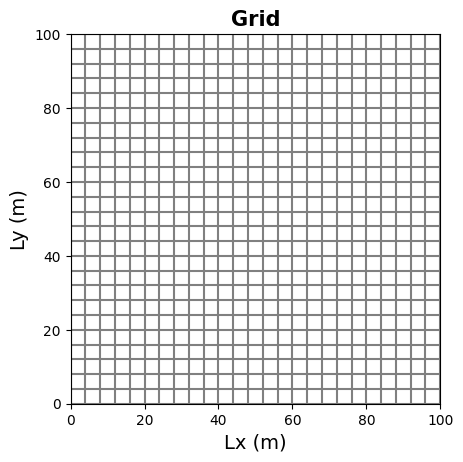

In [4]:
#CHECK GRID
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

 <a name="III"></a>
### III. Assign Cell Activity/Starting Heads and Attach BAS Package

In [5]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
#assign left and right boundary cells to constant head
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
ibound[:,0,:] = -1
ibound[:,-1,:] = -1

#create strt as array of floats = 10m
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, :] = 10.

#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

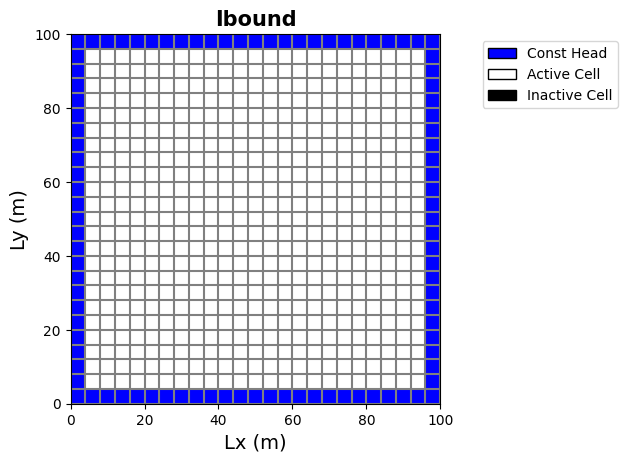

In [6]:
#CHECK IBOUND
#use flopy to plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

 <a name="IV"></a>
### IV. Define Layer Properties and Attach LPF Package

In [7]:
#define horizontal and vertical hydraulic conductivity
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

#define specific storage
ss = np.ones((nlay,nrow,ncol), dtype=np.float32)
ss[:,:,:] = 1e-5

#define layer type as confined
laytyp = np.zeros((nlay,), dtype=np.int32)

#create flopy layer property flow object
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vk, ss=ss, laytyp=laytyp, ipakcb=1)

 <a name="V"></a>
# V. Create Wells and Attach MODFLOW WEL Package

The MODFLOW WEL Package simulates a volumetric flux into or out of a specified model cell in units $\frac{L^3}{T}$. Active wells are specified per stress period and pump/inject at a constant rate throughout that period. 

<img src="https://i.imgur.com/3mZorWX.png" title="MODFLOW well schematic" /></a>

In flopy, wells are specified in a dictionary of stress period data where the stress period key points to a list with a list of data for each active well. This sounds a little confusing, but takes the form:

wel_spd = {stress period: [[lay, row, col, flux], [lay, row, col, flux]....]}

See https://modflowpy.github.io/flopydoc/mfwel.html for more documentation.

For this model, we will create a single well at the center of the domain:                     

In [8]:
#Create Single Well at center of domain with [lay, row, col, flux] list
pumping_rate = -100 #in m^3/d, negative for pumping/positive for injection
well_1 = [0,ncol/2,nrow/2,pumping_rate]

print("Well 1 [layer, row, column, flux]: \n", well_1)

Well 1 [layer, row, column, flux]: 
 [0, 12.5, 12.5, -100]


Note that the row and columns are not integer values but there is no such thing as row "12.5". When implementing your well, flopy will therefore round the layer/rows/columns to the nearest integer layer/row/column and put the well there. Hence, the well in this example will be placed in cell (0,13,13). (We will check this by using flopy to plot the well locations after attaching the well package below.)

Additionally, flopy's cell indexing starts at (0,0) at the top  left corner of the grid whereas the unit axes (Lx, Ly) start at the bottom left. This is a little wierd, but makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. This is just something to keep in mind when assigning a new well's cell location.

We now create a dictionary with a list of all the wells active during our single stress period model. Since we only have 1 well, this list will just contain the information for well 1. (Remember, python indexing starts at zero, so the key 0 corresponds to stress period 1!)

In [9]:
#Create Dictionary With Stress Period Data
wel_spd = {0: [well_1]}

print("Well Stress Period Data: \n", wel_spd)

Well Stress Period Data: 
 {0: [[0, 12.5, 12.5, -100]]}


Now that we've created our stress period data, we use <strong>wel_spd</strong> to make the 'wel' flopy object which will later be used to attach the MODFLOW WEL package to our model.

In [10]:
#Create flopy wel object 
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

To make sure our well is where we want it, we can visualize its location using the plot_bc() function of flopy ModelMap and  specifying the file type we wish to plot as the well file. (ftype='WEL')

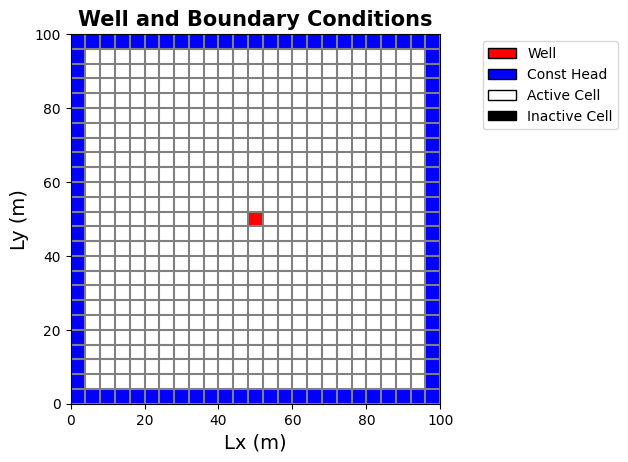

In [11]:
#CHECK WELL LOCATION
#use flopy to plot grid, ibound, and wells
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
wel = modelmap.plot_bc(ftype='WEL')
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Well and Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='red',label='Well',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

 <a name="VI"></a>
### VI. Specify Data Output and Attach OC Package

In [12]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}

#create flopy output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

<a name="VII"></a>
### VII. Assign PCG as Finite Difference Solver and Attach PCG Package

In [13]:
#assign groundwater flow solver
pcg = flopy.modflow.ModflowPcg(model=m)

 <a name="VIII"></a>
### VIII. Create MODFLOW files and Run Model

In [14]:
#write MODFLOW input files
m.write_input()

In [15]:
# Run the model
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Pumping_Model_Check.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/04 19:50:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/04 19:50:49
 Elapsed run time:  0.027 Seconds

  Normal termination of simulation


<a name="IX"></a>
### IX. Extract Head and Flow Data 

In [17]:
#extract binary data from head file
headobj = flopy.utils.binaryfile.HeadFile(f'{model_ws}/{modelname}.hds')
head = headobj.get_data(totim=1.0)

In [19]:
#extract binary data from budget file
budgobj = flopy.utils.binaryfile.CellBudgetFile(f'{model_ws}/{modelname}.cbc')
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)

<a name="X"></a>
## X. Plotting

### Head Contour and Flow Plot 

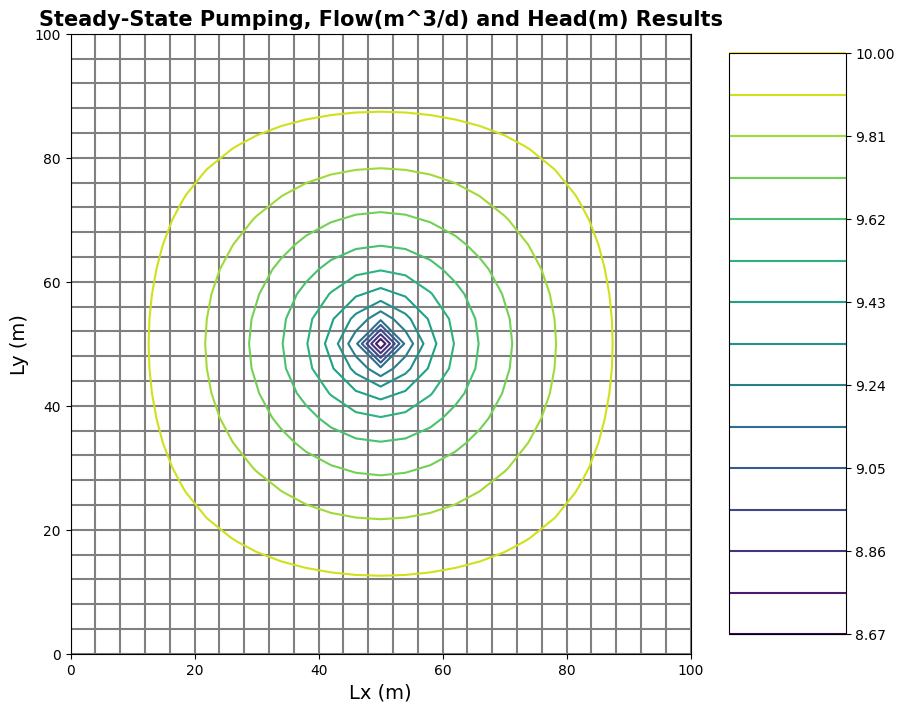

In [20]:
#plot results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Pumping, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)



### Head Contour Plot

The aquifer head may be more easily visualized with a filled contour plot using matplotlib's contourf() function.

<strong> Note: </strong> Flopy takes cell indexing where the top left of the grid is the (0,0) cell index while the Length & Width units start at 0 in the lower left of the grid. This seems a little wierd, but it makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. Flopy's plotting capabilities automatically flip the resultant head data to display on its proper grid, however, for the rest of the plots below, you'll see the function np.flipud() is used to flip the data array to plot in the same direction.

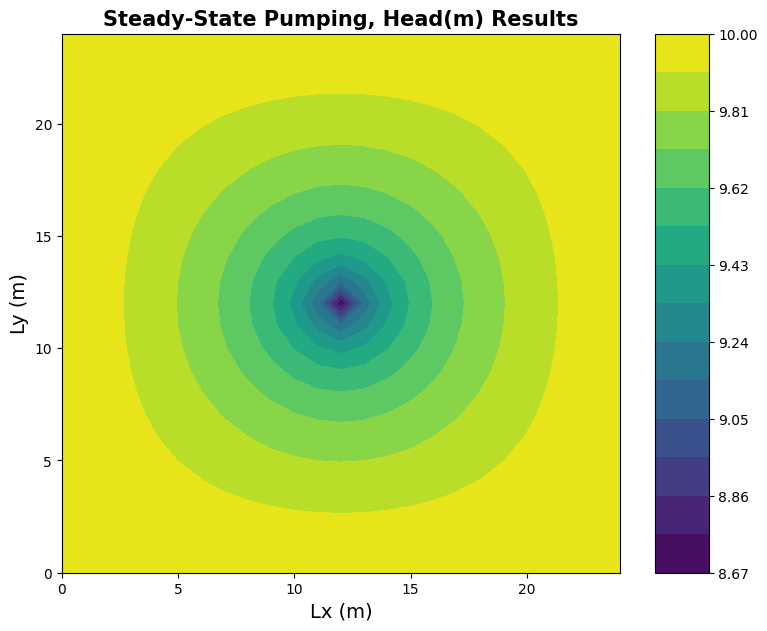

In [21]:
#create plot
plt.figure(figsize=(9,7))
cf = plt.contourf(np.flipud(head[0,:,:]),levels=contour_levels)
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Pumping, Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(cf,aspect=10)
plt.show()

In this simulation, it's interesting to note the effect of the boundary conditions on the head profile near the edges of the model, as well as the effect of the grid on the head profile near the well. The contour lines are slightly squared at the points closest to the corners of the grid as there is a greater distance to a constant head cell and hence there may be more draw down at these points. Additionally, the head contours are distorted to be sort of diamond shaped at the point of pumping as the coarse grid size compromises the ability to resolve greater head changes at this point.

<strong> Activity: </strong> Rerun the model with a refined grid spacing (increase nrow and ncol). How does this change the shape of the head contours near the point of pumping? 

<strong> Advanced Activity: </strong> Write a code to create an ibound variable that sets constant head cells in a more "circular" boundary around the well. What happens to the head contours near the boundaries now? 

### 3D Head Surface Plot

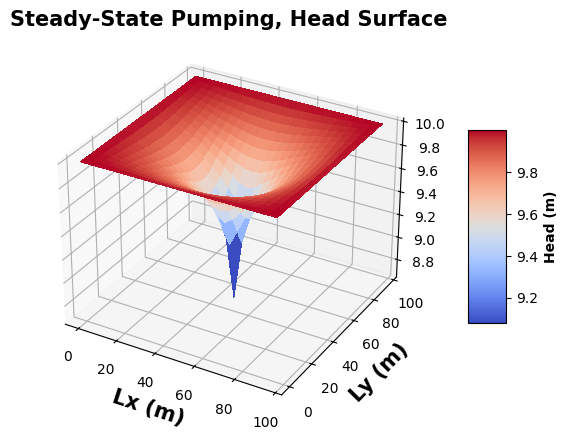

In [22]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d, ax = plt.subplots(1,1, figsize=(12,5), subplot_kw={'projection': '3d'})

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Pumping, Head Surface', fontsize=15, fontweight='bold')
plt.show(surf)

### Head Transect Plot

It may also be helpful to visualize the head profile along a single row. Below the head head data is extracted halfway up Ly and plotted across Lx.

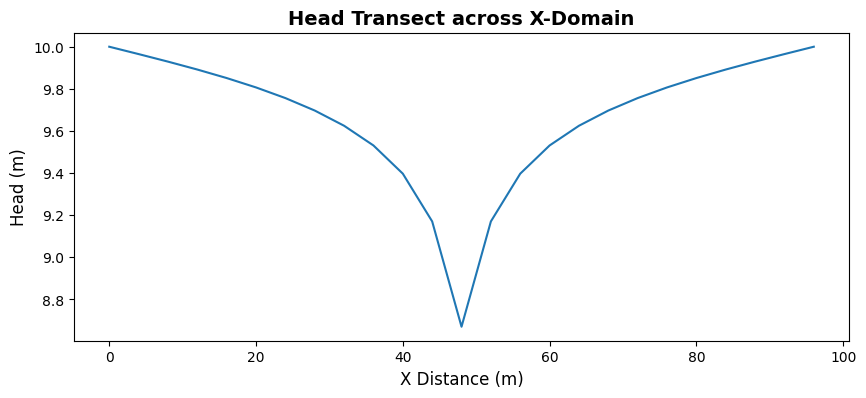

[10.        9.965041  9.929231  9.891652  9.851242  9.806669  9.756128
  9.696948  9.62472   9.531104  9.397233  9.170459  8.670459  9.170459
  9.397233  9.531104  9.62472   9.696948  9.756128  9.806669  9.851242
  9.891652  9.929231  9.965041 10.      ]


In [23]:
#plot head head transect
plt.figure(figsize = (10,4))
x = np.arange(0,Lx,dx)
plt.plot(x,np.flipud(head[0])[int(nrow/2)][:])
plt.title('Head Transect across X-Domain',fontweight = 'bold', fontsize = 14)
plt.xlabel('X Distance (m)',fontsize = 12)
plt.ylabel('Head (m)',fontsize = 12)
plt.show()
print(np.flipud(head[0])[int(nrow/2)][:])

<strong> Activities: </strong> 
- Increase pumping rates and observe the changes in head surface/drawdown extent.
- Add another pumping well variable, well_2, to the well package and rerun the model with two wells.
- Change the location of well_1 and observe different interactions with the constant head boundary conditions.
- Change the IBOUND to accomodate active flux boundaries on the top and bottom of the model edges and observe differences in head surface symmetry.